In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print('Libraries imported!')

Libraries imported!


In [188]:
# importing training and test dataset from github repo

df_train = pd.read_csv("https://github.com/galib96/housing-price-prediction-regression/raw/main/Data/train.csv", encoding='UTF-8')

df_test = pd.read_csv("https://github.com/galib96/housing-price-prediction-regression/raw/main/Data/test.csv", encoding='UTF-8')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [189]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [190]:
# Extracting output features from training set

Y = df_train.iloc[:,-1]
Y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [191]:
# merging training and test set for data preprocessing

df_combined = pd.concat([df_train, df_test], axis=0)

df_combined.drop(columns=['SalePrice'], axis=1, inplace=True)

df_combined.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Data Pre-Processing

In [192]:
# checking for null values for training data
null_check = df_combined.isnull().sum()
null_columns = {}
for key,value in null_check.iteritems():
    if value > 0:
        print(key,",",value)
        null_columns[key] = value

MSZoning , 4
LotFrontage , 486
Alley , 2721
Utilities , 2
Exterior1st , 1
Exterior2nd , 1
MasVnrType , 24
MasVnrArea , 23
BsmtQual , 81
BsmtCond , 82
BsmtExposure , 82
BsmtFinType1 , 79
BsmtFinSF1 , 1
BsmtFinType2 , 80
BsmtFinSF2 , 1
BsmtUnfSF , 1
TotalBsmtSF , 1
Electrical , 1
BsmtFullBath , 2
BsmtHalfBath , 2
KitchenQual , 1
Functional , 2
FireplaceQu , 1420
GarageType , 157
GarageYrBlt , 159
GarageFinish , 159
GarageCars , 1
GarageArea , 1
GarageQual , 159
GarageCond , 159
PoolQC , 2909
Fence , 2348
MiscFeature , 2814
SaleType , 1


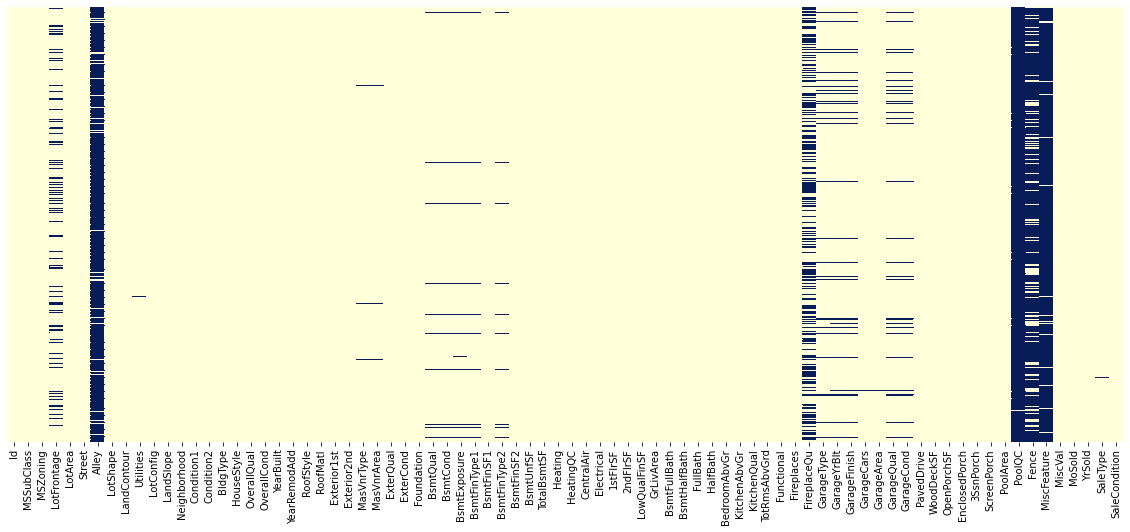

In [193]:
# heatmap of null

plt.figure(figsize=(20,8))
sns.heatmap(df_combined.isnull(),yticklabels=False, cmap="YlGnBu", cbar=False)

In [194]:
# data types and information of df_train (training dataset)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [195]:
# converting MSSubClass to categorical

df_combined['MSSubClass'] = df_combined['MSSubClass'].astype(str) 

In [196]:
# Extracting numerical variables and categorical variables

cat_columns = list(df_combined.loc[:,df_combined.dtypes == 'object'].columns.values)
quant_columns = list(df_combined.loc[:,df_combined.dtypes != 'object'].columns.values)

print("Categorical Features: ",cat_columns)
print("Quantitative Features: ",quant_columns)

Categorical Features:  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Quantitative Features:  ['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars

In [197]:
# handling numerical variables

for column in quant_columns:
    if column in null_check.keys():

        # For GarageYrBlt feature, na values are replaced with the minimum value and 0 for all other columns.
        if column == 'GarageYrBlt':
            df_combined[column].fillna(df_combined[column].min(), inplace = True)
        else:
            df_combined[column].fillna(0, inplace = True)


In [198]:
# handling categoricsl variables

# creating a list of common features that should not be NA as they should be common to all houses
cat_columns_com = ['MSZoning','Utilities','Exterior1st','KitchenQual','Electrical','Functional','SaleType']

for column in null_check.keys():
    if column in cat_columns_com:
        df_combined[column].fillna(df_combined[column].mode()[0], inplace = True)
    elif column in cat_columns:
        df_combined[column].fillna('NA', inplace = True)

In [199]:
# converting categorical variables to numerical where categorical variables indicates quality incrementally or as ranks

df_combined['Street'] = df_combined['Street'].map({'Grvl':1, 'Pave':2})
df_combined['Alley'] = df_combined['Alley'].map({'NA':0, 'Grvl':1, 'Pave':2})
df_combined['Functional'] = df_combined['Functional'].map({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1})
df_combined['FireplaceQu'] = df_combined['FireplaceQu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
df_combined['GarageFinish'] = df_combined['GarageFinish'].map({'Fin':4,'RFn':3,'Unf':2,'NA':0})
df_combined['GarageQual'] = df_combined['GarageQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
df_combined['GarageCond'] = df_combined['GarageCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
df_combined['PavedDrive'] = df_combined['PavedDrive'].map({'N':1, 'P':2, 'Y':3})
df_combined['PoolQC'] = df_combined['PoolQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'NA':0})
df_combined['Fence'] = df_combined['Fence'].map({'GdPrv':4,'MnPrv':2,'GdWo':3,'MnWw':1,'NA':0})
df_combined['KitchenQual'] = df_combined['KitchenQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
df_combined['BsmtCond'] = df_combined['BsmtCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
df_combined['BsmtQual'] = df_combined['BsmtQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
df_combined['ExterCond'] = df_combined['ExterCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_combined['ExterQual'] = df_combined['ExterQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_combined['HeatingQC'] = df_combined['HeatingQC'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_combined['Utilities'] = df_combined['Utilities'].map({'ELO':4,'NoSeWa':2,'NoSeWr':2,'AllPub':1})

# removing new numerical features from categorical feature list
cat_columns = list(set(cat_columns) - set(['Street','Alley','Functional','FireplaceQu','GarageFinish','GarageQual',\
                                           'GarageCond','PavedDrive','PoolQC','Fence','KitchenQual','BsmtFinType1','BsmtFinType2',\
                                           'BsmtCond','BsmtQual','ExterCond','ExterQual','HeatingQC','Utilities']))

In [200]:
# Extracting Age of Remodelling, Age of the house from built year and Age of garage

df_combined['AgeSold'] = df_combined['YrSold'] - df_combined['YearBuilt']
df_combined['AgeRemod'] = df_combined['YrSold'] - df_combined['YearRemodAdd']
df_combined['AgeGarage'] = df_combined['YrSold'] - df_combined['GarageYrBlt']

# Replacing negative values with zeros. Some ages are negative due the work done after houe was sold.
def neg_remove(x):
    """
    takes in x value 
    returns 0 if x is less than 1 otherwise x remains unchanged.
    """
    if x < 0:
        return 0
    else:
        return x

df_combined['AgeSold'] = df_combined['AgeSold'].apply(neg_remove)
df_combined['AgeRemod'] = df_combined['AgeRemod'].apply(neg_remove)
df_combined['AgeGarage'] = df_combined['AgeGarage'].apply(neg_remove)

# dropping YrSold, YearRemodAdd, YearBuilt, GarageYrBlt columns from dataframe
df_combined.drop(columns=['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'], axis=1, inplace=True)

cat_columns = list(set(cat_columns) - set(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']))

# adding new columns to quantitative feature list
quant_columns = quant_columns+['AgeSold','AgeRemod','AgeGarage']

## Some Exploration to learn about the correlations

In [201]:
# summary statistics of SalePrice column in df_train

df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Histogram of Sale Price')

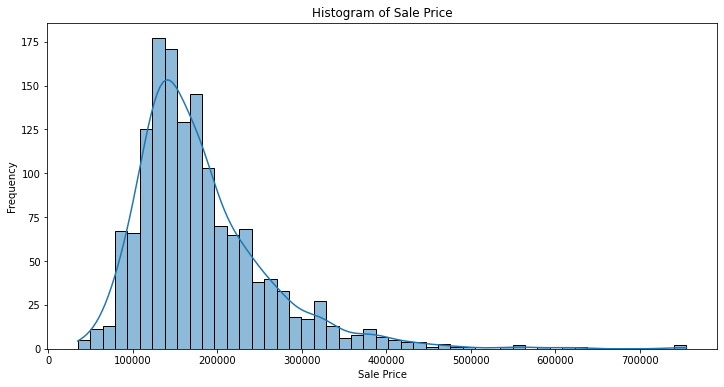

In [202]:
# plotting histogram of SalePrice column in df_train

plt.figure(figsize=(12,6))
sns.histplot(df_train["SalePrice"], kde=True)
plt.ylabel('Frequency')
plt.xlabel('Sale Price')
plt.title('Histogram of Sale Price')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


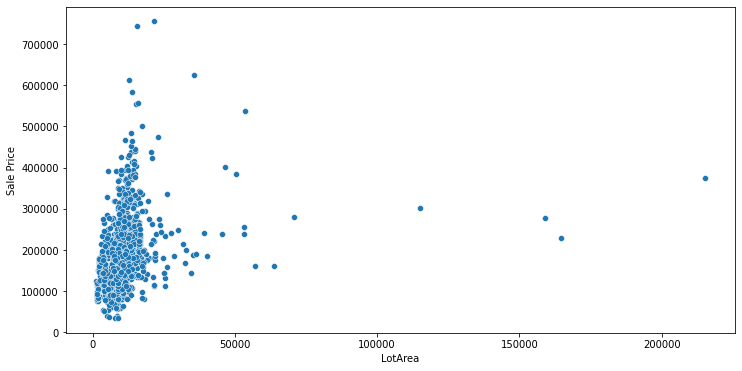

In [203]:
# scatter plot of LotArea vs SalePrice

plt.figure(figsize=(12,6))
sns.scatterplot(df_train['LotArea'], df_train['SalePrice'])
plt.ylabel("Sale Price")
plt.xlabel("LotArea")
plt.show()

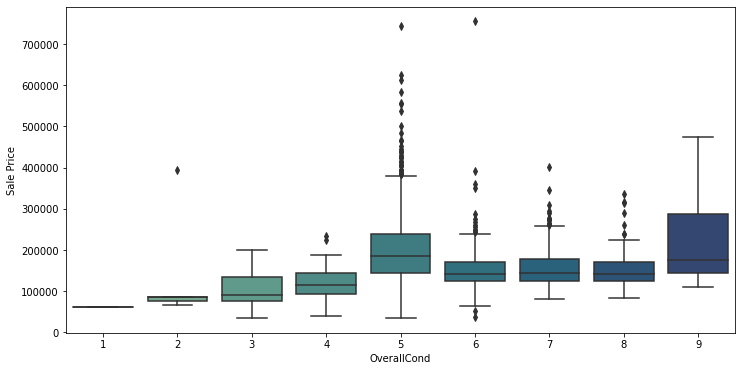

In [204]:
# Box plot OverallCond vs SalePrice

plt.figure(figsize=(12,6))
sns.boxplot(x="OverallCond", y="SalePrice",data=df_train,palette="crest") 
plt.ylabel("Sale Price")
plt.xlabel("OverallCond")
plt.show()

In [205]:
corr_train = df_train.corr()
corr_train.style.background_gradient(cmap='crest').set_precision(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.00,0.01,-0.01,-0.03,-0.03,0.01,-0.01,-0.02,-0.05,-0.01,-0.01,-0.01,-0.02,0.01,0.01,-0.04,0.01,0.00,-0.02,0.01,0.01,0.04,0.00,0.03,-0.02,0.00,0.02,0.02,-0.03,-0.00,0.00,-0.05,0.00,0.06,-0.01,0.02,0.00,-0.02
MSSubClass,0.01,1.00,-0.39,-0.14,0.03,-0.06,0.03,0.04,0.02,-0.07,-0.07,-0.14,-0.24,-0.25,0.31,0.05,0.07,0.00,-0.00,0.13,0.18,-0.02,0.28,0.04,-0.05,0.09,-0.04,-0.10,-0.01,-0.01,-0.01,-0.04,-0.03,0.01,-0.01,-0.01,-0.02,-0.08
LotFrontage,-0.01,-0.39,1.00,0.43,0.25,-0.06,0.12,0.09,0.19,0.23,0.05,0.13,0.39,0.46,0.08,0.04,0.40,0.10,-0.01,0.20,0.05,0.26,-0.01,0.35,0.27,0.07,0.29,0.34,0.09,0.15,0.01,0.07,0.04,0.21,0.00,0.01,0.01,0.35
LotArea,-0.03,-0.14,0.43,1.00,0.11,-0.01,0.01,0.01,0.10,0.21,0.11,-0.00,0.26,0.30,0.05,0.00,0.26,0.16,0.05,0.13,0.01,0.12,-0.02,0.19,0.27,-0.02,0.15,0.18,0.17,0.08,-0.02,0.02,0.04,0.08,0.04,0.00,-0.01,0.26
OverallQual,-0.03,0.03,0.25,0.11,1.00,-0.09,0.57,0.55,0.41,0.24,-0.06,0.31,0.54,0.48,0.30,-0.03,0.59,0.11,-0.04,0.55,0.27,0.10,-0.18,0.43,0.40,0.55,0.60,0.56,0.24,0.31,-0.11,0.03,0.06,0.07,-0.03,0.07,-0.03,0.79
OverallCond,0.01,-0.06,-0.06,-0.01,-0.09,1.00,-0.38,0.07,-0.13,-0.05,0.04,-0.14,-0.17,-0.14,0.03,0.03,-0.08,-0.05,0.12,-0.19,-0.06,0.01,-0.09,-0.06,-0.02,-0.32,-0.19,-0.15,-0.00,-0.03,0.07,0.03,0.05,-0.00,0.07,-0.00,0.04,-0.08
YearBuilt,-0.01,0.03,0.12,0.01,0.57,-0.38,1.00,0.59,0.32,0.25,-0.05,0.15,0.39,0.28,0.01,-0.18,0.20,0.19,-0.04,0.47,0.24,-0.07,-0.17,0.10,0.15,0.83,0.54,0.48,0.22,0.19,-0.39,0.03,-0.05,0.00,-0.03,0.01,-0.01,0.52
YearRemodAdd,-0.02,0.04,0.09,0.01,0.55,0.07,0.59,1.00,0.18,0.13,-0.07,0.18,0.29,0.24,0.14,-0.06,0.29,0.12,-0.01,0.44,0.18,-0.04,-0.15,0.19,0.11,0.64,0.42,0.37,0.21,0.23,-0.19,0.05,-0.04,0.01,-0.01,0.02,0.04,0.51
MasVnrArea,-0.05,0.02,0.19,0.10,0.41,-0.13,0.32,0.18,1.00,0.26,-0.07,0.11,0.36,0.34,0.17,-0.07,0.39,0.09,0.03,0.28,0.20,0.10,-0.04,0.28,0.25,0.25,0.36,0.37,0.16,0.13,-0.11,0.02,0.06,0.01,-0.03,-0.01,-0.01,0.48
BsmtFinSF1,-0.01,-0.07,0.23,0.21,0.24,-0.05,0.25,0.13,0.26,1.00,-0.05,-0.50,0.52,0.45,-0.14,-0.06,0.21,0.65,0.07,0.06,0.00,-0.11,-0.08,0.04,0.26,0.15,0.22,0.30,0.20,0.11,-0.10,0.03,0.06,0.14,0.00,-0.02,0.01,0.39


In [206]:
# corr_train.to_csv('correllation_columns.csv')

## Data Wrangling

In [207]:
# concatenating training and test data.

train_test_df = df_combined.copy()
train_test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,AgeSold,AgeRemod,AgeGarage
0,1,60,RL,65.0,8450,2,0,Reg,Lvl,1,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,No,6,706.0,1,0.0,150.0,856.0,GasA,5,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,8,0,0,Attchd,3,2.0,548.0,3,3,3,0,61,0,0,0,0,0,0,NA,0,2,WD,Normal,5,5,5.0
1,2,20,RL,80.0,9600,2,0,Reg,Lvl,1,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,Gd,5,978.0,1,0.0,284.0,1262.0,GasA,5,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,8,1,3,Attchd,3,2.0,460.0,3,3,3,298,0,0,0,0,0,0,0,NA,0,5,WD,Normal,31,31,31.0
2,3,60,RL,68.0,11250,2,0,IR1,Lvl,1,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,Mn,6,486.0,1,0.0,434.0,920.0,GasA,5,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,8,1,3,Attchd,3,2.0,608.0,3,3,3,0,42,0,0,0,0,0,0,NA,0,9,WD,Normal,7,6,7.0
3,4,70,RL,60.0,9550,2,0,IR1,Lvl,1,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,No,5,216.0,1,0.0,540.0,756.0,GasA,4,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,8,1,4,Detchd,2,3.0,642.0,3,3,3,0,35,272,0,0,0,0,0,NA,0,2,WD,Abnorml,91,36,8.0
4,5,60,RL,84.0,14260,2,0,IR1,Lvl,1,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,Av,6,655.0,1,0.0,490.0,1145.0,GasA,5,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,8,1,3,Attchd,3,3.0,836.0,3,3,3,192,84,0,0,0,0,0,0,NA,0,12,WD,Normal,8,8,8.0


In [208]:
# checking the tail part of the combined dataframe

train_test_df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,AgeSold,AgeRemod,AgeGarage
1454,2915,160,RM,21.0,1936,2,0,Reg,Lvl,1,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,Gable,CompShg,CemntBd,CmentBd,None,0.0,3,3,CBlock,3,3,No,1,0.0,1,0.0,546.0,546.0,GasA,4,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,8,0,0,NA,0,0.0,0.0,0,0,3,0,0,0,0,0,0,0,0,NA,0,6,WD,Normal,36,36,111.0
1455,2916,160,RM,21.0,1894,2,0,Reg,Lvl,1,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,Gable,CompShg,CemntBd,CmentBd,None,0.0,3,3,CBlock,3,3,No,3,252.0,1,0.0,294.0,546.0,GasA,3,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,8,0,0,CarPort,2,1.0,286.0,3,3,3,0,24,0,0,0,0,0,0,NA,0,4,WD,Abnorml,36,36,36.0
1456,2917,20,RL,160.0,20000,2,0,Reg,Lvl,1,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,3,No,5,1224.0,1,0.0,0.0,1224.0,GasA,5,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,3,7,8,1,3,Detchd,2,2.0,576.0,3,3,3,474,0,0,0,0,0,0,0,NA,0,9,WD,Abnorml,46,10,46.0
1457,2918,85,RL,62.0,10441,2,0,Reg,Lvl,1,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,Gable,CompShg,HdBoard,Wd Shng,None,0.0,3,3,PConc,4,3,Av,6,337.0,1,0.0,575.0,912.0,GasA,3,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,3,6,8,0,0,NA,0,0.0,0.0,0,0,3,80,32,0,0,0,0,0,2,Shed,700,7,WD,Normal,14,14,111.0
1458,2919,60,RL,74.0,9627,2,0,Reg,Lvl,1,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,3,3,PConc,4,3,Av,2,758.0,1,0.0,238.0,996.0,GasA,5,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,3,9,8,1,3,Attchd,4,3.0,650.0,3,3,3,190,48,0,0,0,0,0,0,NA,0,11,WD,Normal,13,12,13.0


In [209]:
# shape of combined df
train_test_df.drop(columns=['Id'], axis=1, inplace=True)
train_test_df.shape

(2919, 78)

In [210]:
# get dummy form categorical variables

train_test_df = pd.get_dummies(train_test_df, columns = cat_columns, drop_first = True)

train_test_df.head()

,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,...,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotShape_IR2,LotShape_IR3,LotShape_Reg
0,65.0,8450,2,0,1,7,5,196.0,4,3,4,3,6,706.0,1,0.0,150.0,856.0,5,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,8,0,0,3,2.0,548.0,3,3,3,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,80.0,9600,2,0,1,6,8,0.0,3,3,4,3,5,978.0,1,0.0,284.0,1262.0,5,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,8,1,3,3,2.0,460.0,3,3,3,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,68.0,11250,2,0,1,7,5,162.0,4,3,4,3,6,486.0,1,0.0,434.0,920.0,5,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,8,1,3,3,2.0,608.0,3,3,3,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,60.0,9550,2,0,1,7,5,0.0,3,3,3,4,5,216.0,1,0.0,540.0,756.0,4,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,8,1,4,2,3.0,642.0,3,3,3,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,84.0,14260,2,0,1,8,5,350.0,4,3,4,3,6,655.0,1,0.0,490.0,1145.0,5,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,8,1,3,3,3.0,836.0,3,3,3,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [211]:
train_test_df.shape

(2919, 222)

In [212]:
# extracting original training and test dataset from combined dataframe

df_train = train_test_df.iloc[:1460,:]
df_test = train_test_df.iloc[1460:,:]

In [213]:
# min-max normalize data in training and test set

df_train = df_train.apply(pd.to_numeric)
df_test = df_test.apply(pd.to_numeric)

norm_mean = df_train.mean()
norm_std = df_train.std()

df_train_norm = (df_train - norm_mean)/norm_std
df_test_norm = (df_test - norm_mean)/norm_std

mean_price = Y.mean()
std_price = Y.std()
Y = (Y-Y.mean())/Y.std()

In [214]:
df_test_norm.dropna(axis='columns', inplace=True)
df_train_norm.dropna(axis='columns', inplace=True)

In [215]:
# Extracting input features from training set

last_index = df_train.shape[1] - 1
# X = df_train.iloc[:,:last_index]
X = df_train_norm.copy()
X.head()

,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,...,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotShape_IR2,LotShape_IR3,LotShape_Reg
0,0.212804,-0.207071,0.064216,-0.242942,-0.026171,0.651256,-0.517023,0.513928,1.051942,-0.238031,0.582968,0.117844,1.164313,0.575228,-0.277094,-0.288554,-0.944267,-0.459145,0.890874,-0.793162,1.161454,-0.120201,0.370207,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.735742,0.911897,0.236962,-0.950901,-1.007988,0.333114,0.311618,0.350880,0.262452,0.265527,0.289646,...,-0.083017,-0.144792,-0.761373,-0.222645,-0.052396,-0.091003,-0.330677,1.969844,-0.206949,-0.105227,-0.203325,-0.117811,-0.192111,-0.037024,-0.105227,-0.203325,-0.139784,2.954209,-0.190187,-0.27107,-0.239094,-0.161194,-0.108503,-0.186288,-0.426687,-0.07873,-0.229337,-0.169923,-0.235877,-0.289539,-0.131946,-0.230986,-0.205144,-0.250096,-0.131946,-0.163415,-0.087099,-0.169923,-0.083017,0.760251
1,0.645526,-0.091855,0.064216,-0.242942,-0.026171,-0.071812,2.178881,-0.570555,-0.689368,-0.238031,0.582968,0.117844,0.689879,1.171591,-0.277094,-0.288554,-0.641008,0.466305,0.890874,0.257052,-0.794891,-0.120201,-0.482347,-0.819684,3.947457,0.789470,-0.761360,0.163723,-0.211381,-0.770827,-0.318574,0.236962,0.600289,0.648668,0.333114,0.311618,-0.060710,0.262452,0.265527,0.289646,...,-0.083017,-0.144792,1.312517,-0.222645,-0.052396,-0.091003,-0.330677,-0.507307,-0.206949,-0.105227,-0.203325,-0.117811,-0.192111,-0.037024,-0.105227,-0.203325,-0.139784,-0.338268,-0.190187,-0.27107,-0.239094,-0.161194,-0.108503,-0.186288,-0.426687,-0.07873,-0.229337,-0.169923,-0.235877,-0.289539,-0.131946,-0.230986,-0.205144,-0.250096,-0.131946,-0.163415,11.473319,-0.169923,-0.083017,0.760251
2,0.299349,0.073455,0.064216,-0.242942,-0.026171,0.651256,-0.517023,0.325803,1.051942,-0.238031,0.582968,0.117844,1.164313,0.092875,-0.277094,-0.288554,-0.301540,-0.313261,0.890874,-0.627611,1.188943,-0.120201,0.514836,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.735742,-0.318574,0.236962,0.600289,0.648668,0.333114,0.311618,0.631510,0.262452,0.265527,0.289646,...,-0.083017,-0.144792,-0.761373,-0.222645,-0.052396,-0.091003,-0.330677,1.969844,-0.206949,-0.105227,-0.203325,-0.117811,-0.192111,-0.037024,-0.105227,-0.203325,-0.139784,2.954209,-0.190187,-0.27107,-0.239094,-0.161194,-0.108503,-0.186288,-0.426687,-0.07873,-0.229337,-0.169923,-0.235877,-0.289539,-0.131946,-0.230986,-0.205144,-0.250096,-0.131946,-0.163415,-0.087099,-0.169923,-0.083017,-1.314453
3,0.068564,-0.096864,0.064216,-0.242942,-0.026171,0.651256,-0.517023,-0.570555,-0.689368,-0.238031,-0.557961,1.928918,0.689879,-0.499103,-0.277094,-0.288554,-0.061648,-0.687089,-0.151334,-0.521555,0.936955,-0.120201,0.383528,1.107431,-0.240978,-1.025689,-0.761360,0.163723,-0.211381,0.735742,0.296662,0.236962,0.600289,1.200886,-0.647423,1.649742,0.790533,0.262452,0.265527,0.289646,...,-0.083017,-0.144792,-0.761373,-0.222645,-0.052396,-0.091003,-0.330677,-0.507307,4.828804,-0.105227,-0.203325,-0.117811,-0.19

In [216]:
df_test.shape

(1459, 222)

In [217]:
# converting dataframe to arrays

x_arr = X.values
y_arr = Y.values
print('feature array shape:', x_arr.shape)
print('label array shape:', y_arr.shape)

feature array shape: (1460, 220)
label array shape: (1460,)


In [218]:
# investigating feature importance by XGBoost



In [219]:
# Creating function to get a untrained model from tensorflow
tf.keras.backend.clear_session()
tf.random.set_seed(10)

def get_model():
  model = Sequential([ 
        Dense(1024, input_shape=(x_arr.shape[1],)),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.25),

        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),

        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.15),

        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.05),
        
        Dense(256,activation='linear'),
        Dense(1)
    ])
  
  model.compile(
        loss='mean_absolute_error',
        optimizer=Adam(learning_rate=0.005,decay=5e-4),
        metrics=['mean_absolute_error']
    )
  
  return model

get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              226304    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [220]:
# running training on tensorflow DNN

cb = EarlyStopping(monitor='val_loss', patience=300,restore_best_weights=True)
model = get_model()

history = model.fit(
    x_arr, y_arr,
    batch_size = 64,
    validation_split = 0.1,
    epochs=1000,
    callbacks=[cb]
)

Epoch 1/1000
21/21 [==============================] - 1s 14ms/step - loss: 5.5303 - mean_absolute_error: 5.5303 - val_loss: 4.6165 - val_mean_absolute_error: 4.6165
Epoch 2/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.9979 - mean_absolute_error: 0.9979 - val_loss: 2.3522 - val_mean_absolute_error: 2.3522
Epoch 3/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.4021 - mean_absolute_error: 0.4021 - val_loss: 2.5624 - val_mean_absolute_error: 2.5624
Epoch 4/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.5258 - mean_absolute_error: 0.5258 - val_loss: 0.6380 - val_mean_absolute_error: 0.6380
Epoch 5/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.3240 - mean_absolute_error: 0.3240 - val_loss: 0.4570 - val_mean_absolute_error: 0.4570
Epoch 6/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.2743 - mean_absolute_error: 0.2743 - val_loss: 0.4900 - val_mean_absolute_error: 0.4900
Epoch 7/1000
21

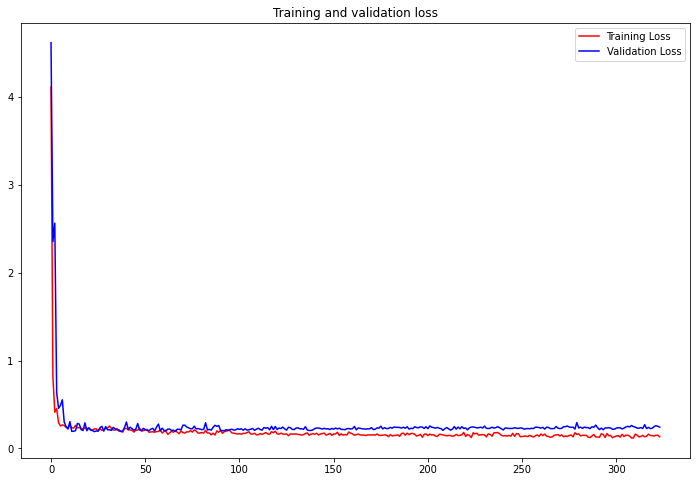

In [221]:
# result of the model training

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [222]:
value_pred = model.predict(df_test_norm.values)

In [223]:
submission_file = pd.read_csv("https://github.com/galib96/housing-price-prediction-regression/raw/main/sample_submission.csv")

submission_file.drop(['SalePrice'], axis=1, inplace=True)
submission_file['SalePrice'] = std_price*value_pred + mean_price
submission_file.head()

,Id,SalePrice
0,1461,131496.140625
1,1462,152528.453125
2,1463,180644.718750
3,1464,190521.031250
4,1465,195602.187500


In [224]:
from google.colab import files
submission_file.to_csv('sample_submission.csv', index=False) 
files.download('sample_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>